In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   datetime import timedelta
import datetime
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
from pyproj import Proj
import oceanlyz
import warnings
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from netCDF4 import Dataset
from netCDF4 import num2date
from pytz import timezone
import pytz



warnings.filterwarnings('ignore')
plt.style.use('default')

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seawater as sw

In [2]:
path_font=r"G:\My drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [3]:
# Funciones
def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def min_ind (value, vector, delta):
    """Función para encontrar la mínima diferencia entre dos celdas
    Input: 
    - Value: valor a encontrar 
    - Vector: vectores donde quiere encontrar dicho valor
    - delta: radio para encontrar ese valor 
    ----------------------------------------------------------------------
    Output: 
    - Ind: indices donde mayor se aproxima el valor buscado a los vectores
    """
    indices = np.where((vector > value-(delta)) & (vector < value+(delta)))[0]
    for i in indices: 
        try :
            if vector[i] - value < vector[i+1] - value:
                ind = i
            else:
                ind = i+1
        except:
            print('**********ERROR************')
    print('Indice:',ind,', Valor:', vector[ind], ', Valor real:', value)

    return ind

# Importar datos

In [16]:
# Batimetría 
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CALIBRACION\BAT_SAI_100m_GENERAL3'
delta = 100
x = np.array ([411994.0299 + i*delta for i in range(226)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1374834.8555 + i*delta for i in range (225)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\IDW_BAT_SAI_GENERAL.txt',skip_header = 6))
z[z < 0] = np.nan # Z donde es tierra

# Suavizar la grilla
kernel = np.ones((1,1))/1.
z_smooth = signal.convolve2d(z, kernel, "same")
z_smooth = np.ma.masked_array(z, mask=np.isnan(z_smooth))
x_new = x.copy()
y_new = y.copy()
z_new = z_smooth.copy()

# Linea de costa data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
data_dir = pjoin(dirname(sio.__file__), r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\Linea_COSTA_UTM") # Definir Ruta
mat_fname = pjoin(data_dir, 'linea_Costa.mat')     # Econtrar el archivo
data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
lc=np.column_stack((xlc,ylc))

In [17]:
print((np.nanmax(y_new) - np.nanmin(y_new))/1000)
print((np.nanmax(x_new) - np.nanmin(x_new))/1000)

22.4
22.5


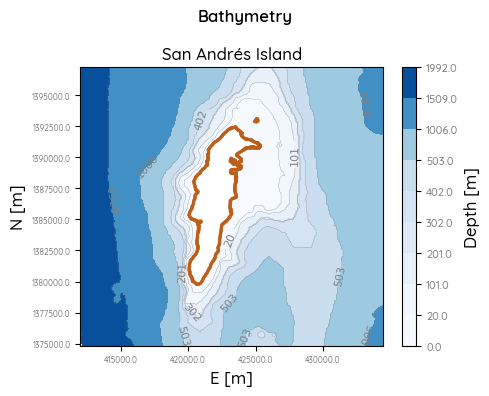

In [18]:
fig, ax = plt.subplots(figsize = (5,4))
colormap = cm.Blues
levels = list(np.round(np.nanmax(z_new)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 99])/100,0))
pc = ax.contourf(x_new, y_new, z_new,levels = levels,cmap=colormap)
cb=plt.colorbar(pc)
a = ax.contour(x_new, y_new, z_new,colors="gray",levels=levels,\
                linewidths=0.2)
labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
ax.set_xlabel ('E [m]',size=12,fontproperties=prop1)
ax.set_ylabel ('N [m]',size=12,fontproperties=prop1)
ax.plot(lc[:,0], lc[:,1], "-k", lw=2)
ax.set_xlim([x_new.min(), x_new.max()])
ax.set_ylim([y_new.min(), y_new.max()])
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
cb.set_label('Depth [m]',size=12,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks(), fontproperties=prop1, color='gray',size=8)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 6)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 6)
fig.suptitle("Bathymetry", size = 12,fontproperties=prop2)     # Titulo de la figura
ax.set_title('San Andrés Island',size = 12,fontproperties=prop1)   # Subtítulo de la figura
ax.plot(lc[:,0], lc[:,1], "-",c='chocolate', lw=2.5, alpha = 0.9)

fig.tight_layout()
# plt.xticks(rotation = 20)
plt.grid(False)

In [19]:
(max(y_new)-min(y_new))

22400.0

# Layer thickness

In [20]:
thickness = np.array([0.05, 0.8, 1.6, 2, 3, 3.7, 5.2, 12.4, 33.45, 37.8])*np.nanmax(z)/100

# Condiciones de frontera

In [7]:
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_200m"
delta = 200                                           # Tamaño de la grilla 
x = np.array ([404758.9787 + i*delta for i in range(203)]) # Menor longitud, Numero de divisiones revisar archivo ASCI (output ARCGIS)
y = np.array ([1368354.4849 + i*delta for i in range (208)])        # Menor Latitud,  Numero de divisiones revisar archivo ASCI (output ARCGIS)
z = np.flipud(np.genfromtxt(path+'\idw_200m.txt',skip_header = 6))
z[z == -9999] = np.nan # Z donde es tierra

In [9]:
# Match whit big grid (200m)
x_min, x_max = np.min(x_new), np.max(x_new)
y_min, y_max = np.min(y_new), np.max(y_new)

indx_min, indx_max = min_ind(value = x_min, vector= x, delta = 200 ), min_ind(value = x_max, vector= x, delta = 200 )
indy_min, indy_max = min_ind(value = y_min, vector= y, delta = 200 ), min_ind(value = y_max, vector= y, delta = 200 )

Indice: 50 , Valor: 414758.9787 , Valor real: 414707.375
Indice: 136 , Valor: 431958.9787 , Valor real: 431907.375
Indice: 44 , Valor: 1377154.4849 , Valor real: 1377008.875
Indice: 138 , Valor: 1395954.4849 , Valor real: 1395908.875


In [10]:
def load_mat_files(path):
    """
    INPUTS: 
    - path: path of file
    ------------------------------------------------------------------------
    OUTPUT:
    - Dictionary of data
    """
    # path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS'
    prop_mat_data = mat73.loadmat(path)
    dic_data = prop_mat_data['data']
    return dic_data

In [13]:
paths_vel = glob.glob(r"C:\Users\paula\Desktop\Files_test14\vel*.mat")
paths_wl = glob.glob(r"C:\Users\paula\Desktop\Files_test14\water*.mat")

In [14]:
# Time
py_datetime = [datetime.datetime.fromordinal(int(i)) + timedelta(days=i%1) - timedelta(days = 366) for i in load_mat_files(paths_vel[0])['Time']]
time_df = [datetime.datetime(i.year, i.month, i.day, i.hour, i.minute, i.second) for i in py_datetime]
minutes = np.array([((time_df[i] - time_df[0]).days*1440)+((time_df[i] - time_df[0]).seconds/60) for i in range (0,len(time_df))])


$f(t)=U+\zeta\sqrt{\frac{g}{d}}$

where $U$ in m/s is depth-averaged velocity in $x$ or ξ direction, $\zeta$ in m is water level above some horizontal plane of reference (datum),  $d$ an $g$ are depth below some horizontal plane of reference (datum) and acceleration due to gravity in m and m/s respectively.

In [15]:
def riemman(u, wl, depth_s, depth_vector):
    """
    Input:
    u:  Velcidad en la coordenada u
    wl: nivel del agua
    depth_s: profundidad de la velocidad u
    depth_vector: profundidades consideradas
    ------------------------------------------------
    Salida:
    ft: función de riemman para la profunidad considerada
    
    """
    g = 9.81
    u_mean = np.nanmean(u[:,np.where(depth_vector == depth_s)[0][0]:], axis= 1)
    ft = u_mean +wl*(np.sqrt(g/depth_s))
    return ft

def dic_rieman(name1):
    dic = {}
    for i, j in zip (paths_vel, paths_wl):
        if (name1 in i)==True:
            print(i,j)
            vel = load_mat_files(i)['Val']
            ws = load_mat_files(j)['Val']
            depth_vector = -load_mat_files(i)['Z'][0]
            for m, h in enumerate(depth_vector):
                ft = riemman(u=vel, wl=ws,depth_s=h, depth_vector=depth_vector)
                if ('A_' in name1) == True:
                    dic.update({m:ft})
                elif ('B_' in name1) == True:
                    dic.update({10+m:ft})
        else:
            pass
    return dic

In [16]:
def dic_rieman(name1):
    dic = {}
    for i, j in zip (paths_vel, paths_wl):
        if (name1 in i)==True:
            print(i,j)
            vel = load_mat_files(i)['Val']
            ws = load_mat_files(j)['Val']
            depth_vector = -load_mat_files(i)['Z'][0]
            for m, h in enumerate(depth_vector):
                ft = riemman(u=vel, wl=ws,depth_s=h, depth_vector=depth_vector)
                if ('A_' in name1) == True:
                    dic.update({m:ft})
                elif ('B_' in name1) == True:
                    dic.update({10+m:ft})
        else:
            pass
    return dic

In [17]:
#-------------Frontera Este--------------------------------------
dic_east = dic_rieman('A_East')
dic_east.update(dic_rieman('B_East'))
df_east = pd.DataFrame(dic_east)
df_east.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'east_boundary.bct'
np.savetxt(path+'/'+name_file, df_east.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\Files_test14\velocity_A_East.mat C:\Users\paula\Desktop\Files_test14\water_level_A_East.mat
C:\Users\paula\Desktop\Files_test14\velocity_B_East.mat C:\Users\paula\Desktop\Files_test14\water_level_B_East.mat


In [18]:
len(df_east)

304

In [19]:
#-------------Frontera Oeste--------------------------------------
dic_west = dic_rieman('A_West')
dic_west.update(dic_rieman('B_West'))
df_west = pd.DataFrame(dic_west)
df_west.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'west_boundary.bct'
np.savetxt(path+'/'+name_file, df_west.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\Files_test14\velocity_A_West.mat C:\Users\paula\Desktop\Files_test14\water_level_A_West.mat
C:\Users\paula\Desktop\Files_test14\velocity_B_West.mat C:\Users\paula\Desktop\Files_test14\water_level_B_West.mat


In [20]:
#-------------Frontera Norte--------------------------------------
dic_north = dic_rieman('A_North')
dic_north.update(dic_rieman('B_North'))
df_north = pd.DataFrame(dic_north)
df_north.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'north_boundary.bct'
np.savetxt(path+'/'+name_file, df_north.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\Files_test14\velocity_A_North.mat C:\Users\paula\Desktop\Files_test14\water_level_A_North.mat
C:\Users\paula\Desktop\Files_test14\velocity_B_North.mat C:\Users\paula\Desktop\Files_test14\water_level_B_North.mat


In [21]:
#-------------Frontera Sur--------------------------------------
dic_south = dic_rieman('A_South')
dic_south.update(dic_rieman('B_South'))
df_south = pd.DataFrame(dic_south)
df_south.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'south_boundary.bct'
np.savetxt(path+'/'+name_file, df_south.values, delimiter=' ', fmt = "%+15.7e")

C:\Users\paula\Desktop\Files_test14\velocity_A_South.mat C:\Users\paula\Desktop\Files_test14\water_level_A_South.mat
C:\Users\paula\Desktop\Files_test14\velocity_B_South.mat C:\Users\paula\Desktop\Files_test14\water_level_B_South.mat


# Constitutivas

In [22]:
path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
data_prop = Dataset(path+'\Hycom_oct21_nov15_2021_6_temp_sal_2.nc','r')
#-------Metadatos-------------------------------------------
lat = np.array(data_prop.variables['latitude'][:])
lon = np.array(data_prop.variables['longitude'][:])
nctime = np.array(data_prop.variables['time'][:])
t_unit = data_prop.variables['time'].units
t_cal = data_prop.variables['time'].calendar
time = num2date(nctime,units=t_unit,calendar=t_cal)#Date time
time_str = np.array([time[i].strftime("%Y-%m-%d %H:%M:%S") for i in range (len(time))])
time = np.array([datetime.datetime.strptime(time_str[i], "%Y-%m-%d %H:%M:%S") for i in range (len(time))])

#------ Cambiar referencia de tiempo a utm-----------------------------------
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])

#---------------------Variables------------------------------------------------
salt = np.array(data_prop.variables['salinity'][:])
salt[salt==-30000] = np.nan
temp = np.array(data_prop.variables['water_temp'][:])
temp[temp==-30000] = np.nan
depth =  np.array(data_prop.variables['depth'][:])

In [23]:
# Profunidades de acuerdo con los espersores del modelo
depth_model = np.cumsum(thickness)

# Profundidades de los datos de reanálisis que hacen más match con los del modelo 
depth_layer = [0, 12, 40, 70, 125, 200, 300, 400, 600, 800]

In [24]:
def constituten(c, depth_s, depth_bd, lat_s, lat_bd, lon_s, lon_bd):
    """
    ------------input------------------------
    c: arreglo de la propiedad constitutiva (temp / sal) 
    depth_s: serie de profundidades 
    lat_bd: Cordenanda latitud 
    lon_bd: Coordenada longitud
    lat_s: serie de latitud 
    lon_s: Serie de longitud
    
    ------------output----------------------------
    constituen: serie de la propiedad constitutiva a la profundida deseada
    
    """
    c= c[:,np.where(depth_s==depth_bd)[0][0], np.where(lat_s==lat_bd)[0][0],np.where(lon_s == lon_bd)[0][0]]
    return c

In [25]:
# Time split
date_ini = datetime.datetime(2021,11,2,1) # Fechas inicial de modelación
date_fin = datetime.datetime(2021,11,14,19,0) # Fechas final de modelación
ind_ini_fin = np.where((time==date_ini)|(time==date_fin))[0]
time_d3d = time[ind_ini_fin[0]:ind_ini_fin[1]]
minutes = np.array([((time_d3d[i] - time_d3d[0]).days*1440)+((time_d3d[i] - time_d3d[0]).seconds/60) for i in range (0,len(time_d3d))])

# Time split of variables
salt_split = salt[ind_ini_fin[0]:ind_ini_fin[1],:,:]
temp_split = temp[ind_ini_fin[0]:ind_ini_fin[1],:,:]

In [26]:
time_d3d

array([datetime.datetime(2021, 11, 2, 1, 0),
       datetime.datetime(2021, 11, 2, 4, 0),
       datetime.datetime(2021, 11, 2, 7, 0),
       datetime.datetime(2021, 11, 2, 10, 0),
       datetime.datetime(2021, 11, 2, 13, 0),
       datetime.datetime(2021, 11, 2, 16, 0),
       datetime.datetime(2021, 11, 2, 19, 0),
       datetime.datetime(2021, 11, 2, 22, 0),
       datetime.datetime(2021, 11, 3, 1, 0),
       datetime.datetime(2021, 11, 3, 4, 0),
       datetime.datetime(2021, 11, 3, 7, 0),
       datetime.datetime(2021, 11, 3, 10, 0),
       datetime.datetime(2021, 11, 3, 13, 0),
       datetime.datetime(2021, 11, 3, 16, 0),
       datetime.datetime(2021, 11, 3, 19, 0),
       datetime.datetime(2021, 11, 3, 22, 0),
       datetime.datetime(2021, 11, 4, 1, 0),
       datetime.datetime(2021, 11, 4, 4, 0),
       datetime.datetime(2021, 11, 4, 7, 0),
       datetime.datetime(2021, 11, 4, 10, 0),
       datetime.datetime(2021, 11, 4, 13, 0),
       datetime.datetime(2021, 11, 4, 16, 0

In [27]:
# Este
#------------------A---------------------------
lat_bd = 12.479999542236328
lon_bd = 278.4000244140625
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})


#-----------------B-------------------------------
lat_bd = 12.600000381469727
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_este = pd.DataFrame(dic_sal)
df_sal_este.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_este_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_este.values, delimiter=' ', fmt = "%+15.7e")

In [28]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_este = pd.DataFrame(dic_temp)
df_temp_este.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_este_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_este.values, delimiter=' ', fmt = "%+15.7e")


In [29]:
# Oeste
#------------------A---------------------------
lat_bd = 12.479999542236328
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})

#-----------------B-------------------------------
lat_bd = 12.600000381469727
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_oeste = pd.DataFrame(dic_sal)
df_sal_oeste.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_oeste_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_oeste.values, delimiter=' ', fmt = "%+15.7e")

In [30]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_oeste = pd.DataFrame(dic_temp)
df_temp_oeste.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_oeste_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_oeste.values, delimiter=' ', fmt = "%+15.7e")

In [31]:
# Sur
#-----------------A---------------------------------
lat_bd = 12.4399995803833
lon_bd = 278.1600341796875
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})

#----------------B------------------------------------
lat_bd = 12.4399995803833
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_sur = pd.DataFrame(dic_sal)
df_sal_sur.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_sur_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_sur.values, delimiter=' ', fmt = "%+15.7e")

In [32]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_sur = pd.DataFrame(dic_temp)
df_temp_sur.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_sur_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_sur.values, delimiter=' ', fmt = "%+15.7e")

In [33]:
# North
#---------A------------------
lat_bd = 12.640000343322754
lon_bd = 278.1600341796875
dic_sal = {}
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({j:c})


#---------B------------------
lat_bd = 12.640000343322754
lon_bd = 278.4000244140625
for j, h in enumerate (depth_layer):
    c = constituten(salt_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_sal.update({10+j:c})

df_sal_norte = pd.DataFrame(dic_sal)
df_sal_norte.insert(loc= 0, column = 'minutes', value = minutes)

path =  r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
name_file = 'salt_norte_boundary.bcc'
np.savetxt(path+'/'+name_file, df_sal_norte.values, delimiter=' ', fmt = "%+15.7e")


In [34]:
dic_temp = {}
for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({j:c})

for j, h in enumerate (depth_layer):
    c = constituten(temp_split, depth, h, lat, lat_bd, lon,lon_bd)
    dic_temp.update({10+j:c})

df_temp_norte = pd.DataFrame(dic_temp)
df_temp_norte.insert(loc= 0, column = 'minutes', value = minutes)

name_file = 'temp_norte_boundary.bcc'
np.savetxt(path+'/'+name_file, df_temp_norte.values, delimiter=' ', fmt = "%+15.7e")

In [35]:
len(df_temp_sur)

102

# Puntos de observación

## Cove

In [21]:
lat_cove = 12.555738
lon_cove = -81.738463
x_cove, y_cove = proj_ZONE17(lon_cove,lat_cove)
ind_xcove = min_ind(value=x_cove, vector=x_new, delta=100)
ind_ycove = min_ind(value=y_cove, vector=y_new, delta=100)
print(ind_xcove,ind_ycove)
list_cove = ['Cove', ind_xcove, ind_ycove]

Indice: 78 , Valor: 419794.0299 , Valor real: 419777.9967201181
Indice: 133 , Valor: 1388134.8555 , Valor real: 1388119.6799451713
78 133


## Barrera

In [22]:
lat_barrera =  12.603483
lon_barrera = -81.678766
x_barrera, y_barrera = proj_ZONE17(lon_barrera,lat_barrera)
ind_xbarrera = min_ind(value=x_barrera, vector=x_new, delta=100)
ind_ybarrera = min_ind(value=y_barrera, vector=y_new, delta=100)
list_barrera = ['Barrera', ind_xbarrera, ind_ybarrera]

Indice: 143 , Valor: 426294.0299 , Valor real: 426277.01849166275
Indice: 186 , Valor: 1393434.8555 , Valor real: 1393382.35178034


## Puuntos de salinidad y temperatura

In [23]:
df_perfiles = pd.read_csv('Coordenas_Perfiles_2.csv')
df_perfiles.drop('Unnamed: 0',axis=1, inplace=True)
df_perfiles.head(4)

in_ts_x = np.zeros(len(df_perfiles['x']))
in_ts_y = np.zeros(len(df_perfiles['y']))

k = 0
for i, j in zip (df_perfiles['x'], df_perfiles['y']):
    in_ts_x[k] = min_ind(value=i, vector=x_new, delta =100)
    in_ts_y[k] = min_ind(value=j, vector=y_new, delta =100)
    k = k+1

ind_name = list('PTS_'+str(i+1) for i in range(len(in_ts_x))) 
df_pts = pd.DataFrame({'ID':ind_name, 'Ind_X':in_ts_x, 'Ind_Y':in_ts_y, 'lon':df_perfiles['lon'],'lat':df_perfiles['lat']})
df_pts.drop_duplicates(subset=['Ind_X', 'Ind_Y'], inplace = True)
df_pts.reset_index(drop=True, inplace=True)

Indice: 140 , Valor: 425994.0299 , Valor real: 425936.0414280868
Indice: 197 , Valor: 1394534.8555 , Valor real: 1394439.5104323549
Indice: 139 , Valor: 425894.0299 , Valor real: 425808.6523279231
Indice: 196 , Valor: 1394434.8555 , Valor real: 1394420.5879379555
Indice: 152 , Valor: 427194.0299 , Valor real: 427170.9467856752
Indice: 181 , Valor: 1392934.8555 , Valor real: 1392858.2999182355
Indice: 156 , Valor: 427594.0299 , Valor real: 427498.1868239869
Indice: 160 , Valor: 1390834.8555 , Valor real: 1390744.8922520124
Indice: 156 , Valor: 427594.0299 , Valor real: 427552.1899286429
Indice: 139 , Valor: 1388734.8555 , Valor real: 1388722.613872698
Indice: 153 , Valor: 427294.0299 , Valor real: 427263.4088631454
Indice: 119 , Valor: 1386734.8555 , Valor real: 1386646.1549718452
Indice: 139 , Valor: 425894.0299 , Valor real: 425807.8723264736
Indice: 106 , Valor: 1385434.8555 , Valor real: 1385424.8331458603
Indice: 120 , Valor: 423994.0299 , Valor real: 423902.1102226691
Indice: 99 ,

## Concatenar puntos

In [24]:
df_plus = pd.DataFrame([list_barrera, list_cove], columns=['ID', 'Ind_X', 'Ind_Y'])
df_ind = pd.concat([df_plus, df_pts[['ID', 'Ind_X', 'Ind_Y']]], ignore_index=True)
df_ind['Ind_X'] = df_ind['Ind_X'].astype('int') 
df_ind['Ind_Y'] = df_ind['Ind_Y'].astype('int') 

In [25]:
# Guardar archivo con puntos de observación
path = r"G:\My drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\CODIGOS"
f =open(path+'\PUNTOS_OBS_SAL_TEMP.obs','w')
for i in range (len(df_ind.ID)):
    a = f'{df_ind.iloc[i].ID:<17}'
    b = f'{df_ind.iloc[i].Ind_X:>8}'
    c = f'{df_ind.iloc[i].Ind_Y:>6}'
    print(a+' '+b+' '+c)
    f.write(a+' '+b+' '+c+'\n')
f.close()

Barrera                143    186
Cove                    78    133
PTS_1                  140    197
PTS_2                  139    196
PTS_3                  152    181
PTS_4                  156    160
PTS_5                  156    139
PTS_6                  153    119
PTS_7                  139    106
PTS_8                  120     99
PTS_9                  112     81
PTS_10                 105     66
PTS_11                  97     46
PTS_12                  81     50
PTS_13                  81     71
PTS_14                  83     92
PTS_15                  79    111
PTS_16                  78    133
PTS_17                  92    152
PTS_18                 103    175
PTS_19                 116    193
PTS_20                  95    153
PTS_21                  93    152
PTS_22                  91    152
PTS_24                  89    152
PTS_25                  86    151
PTS_26                  84    151
PTS_27                  95    157
PTS_28                  92    156
PTS_29        

# Oleaje 

In [12]:
x_norte_sur = [x_min+5800, x_min + 11600]
y_este_oeste = [y_min, y_min + 6333, y_min + 12667, y_max]
print(x_norte_sur, y_este_oeste)

NameError: name 'x_min' is not defined

In [36]:
in_norte_sur = [min_ind(value= j, vector= x, delta =200) for j in x_norte_sur]
in_este_oeste = [min_ind(value= j, vector= y, delta =200) for j in y_este_oeste]

Indice: 79 , Valor: 420558.9787 , Valor real: 420507.375
Indice: 108 , Valor: 426358.9787 , Valor real: 426307.375
Indice: 44 , Valor: 1377154.4849 , Valor real: 1377008.875
Indice: 75 , Valor: 1383354.4849 , Valor real: 1383341.875
Indice: 107 , Valor: 1389754.4849 , Valor real: 1389675.875
Indice: 139 , Valor: 1396154.4849 , Valor real: 1396008.875


In [37]:
print(indx_max, indx_min)
print(indy_max, indy_min)

137 50
139 44


In [38]:
data = Dataset('data_wave_MG.nc','r')
data.variables

{'longitude': <class 'netCDF4._netCDF4.Variable'>
 float32 longitude(longitude)
     units: degrees_east
     long_name: longitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'latitude': <class 'netCDF4._netCDF4.Variable'>
 float32 latitude(latitude)
     units: degrees_north
     long_name: latitude
 unlimited dimensions: 
 current shape = (6,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (1464,)
 filling on, default _FillValue of -2147483647 used,
 'mwd': <class 'netCDF4._netCDF4.Variable'>
 int16 mwd(time, latitude, longitude)
     scale_factor: 0.001146957496767753
     add_offset: 46.49030605692666
     _FillValue: -32767
     missing_value: -32767
     units: Degree true
     long_name: Mean wave directio

In [39]:
%%time
lat_wave = np.array(data.variables['latitude'][:])
lon_wave = np.array(data.variables['longitude'][:])
nctime_wave = np.array(data.variables['time'][:])
t_unit_wave = data.variables['time'].units
t_cal_wave = data.variables['time'].calendar
time_wave = num2date(nctime_wave,units=t_unit_wave,calendar=t_cal_wave)#Date time
hs = np.array(data.variables['swh'][:])
tp = np.array(data.variables['pp1d'][:])
direc = np.array(data.variables['mwd'][:])

CPU times: total: 0 ns
Wall time: 33.1 ms


In [40]:
# Cambiar la zona horaria utc 0 a utc -5
utc = pytz.utc
col_zone = timezone('America/Bogota')
time2=np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute,tzinfo=utc) for i in time_wave])
loc_co =np.array([i.astimezone(col_zone) for i in time2])
time_wave = np.array([datetime.datetime(i.year,i.month,i.day,i.hour,i.minute) for i in loc_co])
time_wave

array([datetime.datetime(2021, 9, 30, 19, 0),
       datetime.datetime(2021, 9, 30, 20, 0),
       datetime.datetime(2021, 9, 30, 21, 0), ...,
       datetime.datetime(2021, 11, 30, 16, 0),
       datetime.datetime(2021, 11, 30, 17, 0),
       datetime.datetime(2021, 11, 30, 18, 0)], dtype=object)

In [41]:
date_ini = datetime.datetime(2021,11,2,1) # Parámetro a variar
date_fin = datetime.datetime(2021,11,14,16) # Parámetro a variar
ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
print(ind_ini_fin)
print(time_d3d_wave.shape)

[ 774 1077]
(303,)


In [42]:
def TEPAR_files_swan(filename,lon, lat, Latitud, Longitud, time_wave, hs, tp, direc , date_ini = datetime.datetime(2021,11,2,1), date_fin = datetime.datetime(2021,11,14,16)):
    """
    filename: Nombre del archivo
    Lon: Coordenada longitudinal del punto de interés
    Lat: Coordenada latitudinal del punto de interés
    Latitud: Serie de coordenadas latitudinales
    Longitud: Serie de coordenadas longitudinales
    date_ini: fecha inicial de la serie de datos
    date_fin: Fecha final de la serie de datos
    """
    in_lat = np.where((Latitud == lat))[0]
    in_lon = np.where((Longitud == lon))[0]
    ind_ini_fin = np.where((time_wave==date_ini)|(time_wave==date_fin))[0]
    
    time_d3d_wave = time_wave[ind_ini_fin[0]:ind_ini_fin[1]]
    str_time_wave =[time_d3d_wave[i].strftime("%Y%m%d.%H%M") for i in range( len(time_d3d_wave))]
    Hs = hs[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Hs = [Hs[i][0] for i in range(len(Hs))]
    Tp = tp[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Tp = [Tp[i][0] for i in range(len(Tp))]
    Direc = direc[ind_ini_fin[0]:ind_ini_fin[1], in_lat, in_lon]
    Direc = [Direc[i][0] for i in range(len(Direc))]
    Des_direc = list(np.ones(shape=len(Direc))*40)
    Dir_Param = {'Time':str_time_wave, 'Hs': Hs, 'Tp': Tp, 'Direc': Direc, 'Des_Dirc': Des_direc}
    df_data = pd.DataFrame(data = Dir_Param)
    with open (filename+'.bnd', "w") as f:
        f.write("TPAR \n")
        np.savetxt(f,df_data,fmt =('%s  %7.9f  %8.9f  %9.9f  %5.1f'))
    return df_data

In [43]:
# Note:
Boundary = 'Norte'
longitudes = [278.250, 278.375]
lat = 12.625
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime.datetime(2021,11,2,0), date_fin = datetime.datetime(2021,11,14,22))

In [44]:
# Sur:
Boundary = 'Sur'
longitudes = [278.250, 278.375]
lat = 12.375
for i in range (len(longitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),longitudes[i], lat, lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime.datetime(2021,11,2,0), date_fin = datetime.datetime(2021,11,14,22))

In [45]:
# Oeste:
Boundary = 'Oeste'
latitudes = [12.375, 12.5, 12.625]
lon = 278.250
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime.datetime(2021,11,2,0), date_fin = datetime.datetime(2021,11,14,22))

In [46]:
# Este:
Boundary = 'Este'
latitudes = [12.375, 12.5, 12.625]
lon = 278.375
for i in range (len(latitudes)):
    df_data = TEPAR_files_swan(Boundary + str(i+1),lon, latitudes[i], lat_wave, lon_wave, time_wave, hs, tp, direc , date_ini = datetime.datetime(2021,11,2,0), date_fin = datetime.datetime(2021,11,14,22))

In [56]:
x_max-x_min

17300.0

In [60]:
(12.5-12.375)*111000

13875.0

In [59]:
y_min-y_max

-19000.0